# Load libraries

In [11]:
import numpy as np
import pandas as pd
import os

# Specify git executable file for GitPython in Jupyter Notebook (In IDE, it can still work without this line.)
os.environ["GIT_PYTHON_GIT_EXECUTABLE"] = "/usr/local/bin/git"

import git
from git import RemoteProgress

from git import Repo
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Clone repo from GitHub

Link: https://git-scm.com/docs/git-clone <br>
<b>Note:</b> In case too-long file path issue occurs in Windows, set <code>git config --system core.longpaths true</code>

In [157]:
class Progress(RemoteProgress):
    def update(self, op_code, cur_count, max_count=None, message=''):
        print(self._cur_line)

In [285]:
remote_link = "https://github.com/vert-x3/vertx-web"
local_link = "/Users/deepsky/Documents/vertx-web"
# Uncomment to clone
# Repo.clone_from(remote_link, local_link, progress=Progress())

In [286]:
repo = Repo(local_link)
fixing_commit = "57a65dce6f4c5aa5e3ce7288685e7f3447eb8f3b"
affected_file = "vertx-web/src/main/java/io/vertx/ext/web/handler/impl/StaticHandlerImpl.java"
affected_file2= "vertx-web/src/test/java/io/vertx/ext/web/handler/StaticHandlerTest.java"

# Show info of a commit
Link: https://git-scm.com/docs/git-show
You can explore different parameters.

In [287]:
show_data = repo.git.show("-s", fixing_commit).splitlines()
for line in show_data:
    print(line)

commit 57a65dce6f4c5aa5e3ce7288685e7f3447eb8f3b
Author: Julien Viet <julien@julienviet.com>
Date:   Thu Sep 20 09:42:30 2018 +0200

    CVE-2018-12542: The StaticHandler uses external input to construct a pathname that should be within a restricted directory, but it does not properly neutralize '\' (forward slashes) sequences that can resolve to a location that is outside of that directory when running on Windows Operating Systems. - fixes #1025


# Show all developers across all branches
Link: https://git-scm.com/docs/git-shortlog

In [288]:
commit_authors = repo.git.shortlog("-sne", "--all").splitlines()

author_commits = []

for commit_author in commit_authors:
    commit, author = commit_author.split("\t")
    author_commits.append([int(commit), author])

In [289]:
df = pd.DataFrame(author_commits, columns=['Commit', 'Author'])

In [290]:
df.head()

,Commit,Author
0,523,Julien Viet <julien@julienviet.com>
1,387,Paulo Lopes <paulo@mlopes.net>
2,333,Paulo Lopes <pmlopes@users.noreply.github.com>
3,276,Paulo Lopes <pmlopes@gmail.com>
4,213,Francesco Guardiani <francescoguard@gmail.com>


## Top 10 most active developers in the project

<AxesSubplot:xlabel='Commit', ylabel='Author'>

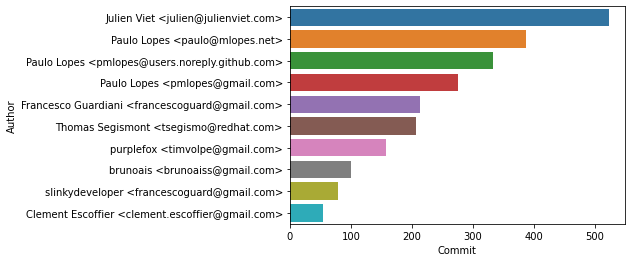

In [291]:
sns.barplot(y='Author', x="Commit", data=df[:10])

# Code changes between 2 commits
<b>Note:</b> Watch out for the initial commit (no parent commit)

In [292]:
diff_data = repo.git.diff(fixing_commit + "^", fixing_commit).splitlines()
for line in diff_data:
    print(line)

diff --git a/vertx-web/src/main/java/io/vertx/ext/web/handler/impl/StaticHandlerImpl.java b/vertx-web/src/main/java/io/vertx/ext/web/handler/impl/StaticHandlerImpl.java
index 7e456617..15f62d9a 100644
--- a/vertx-web/src/main/java/io/vertx/ext/web/handler/impl/StaticHandlerImpl.java
+++ b/vertx-web/src/main/java/io/vertx/ext/web/handler/impl/StaticHandlerImpl.java
@@ -135,14 +135,27 @@ public class StaticHandlerImpl implements StaticHandler {
       if (log.isTraceEnabled()) log.trace("Not GET or HEAD so ignoring request");
       context.next();
     } else {
-      String path = Utils.removeDots(Utils.urlDecode(context.normalisedPath(), false));
-      // if the normalized path is null it cannot be resolved
+      // we are trying to match a URL path to a Filesystem path, so the first step
+      // is to url decode the normalized path so avoid misinterpretations
+      String path = Utils.urlDecode(context.normalisedPath(), false);
+
       if (path == null) {
+        // if the nor

# Identify the last commit that changes a line modified in the current commit

Link: https://git-scm.com/docs/git-blame

In [488]:
blame_data = repo.git.blame("-L 140, +141", fixing_commit,"-2", affected_file).splitlines()
for line in blame_data:
    print(line)

57a65dce6 (Julien Viet 2018-09-20 09:42:30 +0200 140)       String path = Utils.urlDecode(context.normalisedPath(), false);
57a65dce6 (Julien Viet 2018-09-20 09:42:30 +0200 141) 


# Show all the commit history between two commits

Link: https://git-scm.com/docs/git-log <br> Watch out for initial commit (no parent commit)

In [444]:
last_commit = blame_data[0].strip().split()[0]
log_data = repo.git.log(fixing_commit, affected_file).splitlines()
print("Number of commits in between:", len(log_data))

Number of commits in between: 248


In [445]:
log_data

['commit 57a65dce6f4c5aa5e3ce7288685e7f3447eb8f3b',
 'Author: Julien Viet <julien@julienviet.com>',
 'Date:   Thu Sep 20 09:42:30 2018 +0200',
 '',
 "    CVE-2018-12542: The StaticHandler uses external input to construct a pathname that should be within a restricted directory, but it does not properly neutralize '\\' (forward slashes) sequences that can resolve to a location that is outside of that directory when running on Windows Operating Systems. - fixes #1025",
 '',
 'commit e4c9b2cd31b96e9779a218f4ef5b9075ebac06a2',
 'Author: Rb Krishna <krishnarb3@gmail.com>',
 'Date:   Mon Jan 29 14:15:42 2018 +0530',
 '',
 '    Add tests for Http2Push and link preload',
 '    ',
 '    Signed-off-by: Rb Krishna <krishnarb3@gmail.com>',
 '',
 'commit d3e1927fd2ccd255b2d619a770b4e863fc63feaf',
 'Author: Rb Krishna <krishnarb3@gmail.com>',
 'Date:   Fri Jan 12 14:44:31 2018 +0530',
 '',
 '    Remove logs and copy http2push mapping in setHttp2PushMapping when not null',
 '    ',
 '    Signed-off-by

In [467]:
log_data_2 = repo.git.log("--oneline",fixing_commit + "^", affected_file).splitlines()
print("Number of commits in between:", len(log_data))

Number of commits in between: 248


In [468]:
log_data_2

['f78ae334 Fix StaticHandlerTest for java 9 and use tcnative only in Java 8',
 'e4c9b2cd Add tests for Http2Push and link preload',
 'defd10c9 code linting',
 'a63647f8 removed unused imports',
 '18653a37 remove test regarding failure handler which is wrong and added a test showing the new functionality',
 'dec3cc6d compare response content-length with actual file size to make it work with windows line endings',
 'fca5e891 add default content encoding setter',
 '8a0dcfae Update StaticHandlerTest.java',
 '09a24632 Merge pull request #398 from bruders/issues/issue-397',
 '35c882a4 Fixes #428: proper response for invalid ranges',
 '0600b478 Add Vary header when using caching',
 'b10b1a7d Fix #396 Although spec states GMT is assumed to be the same as UTC it expects strings to be formatted in GMT https://www.w3.org/Protocols/rfc2616/rfc2616-sec3.html#sec3.3.1',
 "d74c990c Merge branch 'master' into issues/342",
 'c1c55b4f Fixes #342: do not call twice error handler',
 'e47edce0 Fixes #319: 

In [ ]:
#Task 5. j.

In [340]:
log_author_1 =repo.git.log("--pretty=format:%an",affected_file).splitlines()

In [341]:
list(set(log_author_1))

['Sean Fitts',
 'Arniu',
 'bruder.s@gmail.com',
 'Rb Krishna',
 'slinkydeveloper',
 'Paulo Lopes',
 'Jonas Berlin',
 'Thomas Segismont',
 'Clement Escoffier',
 'qxo',
 'rogelio-o',
 'rrorts']

In [416]:
log_author_2 =repo.git.log("--pretty=format:%an",affected_file2).splitlines()

In [417]:
list(set(log_author_2))

['bruder.s@gmail.com',
 'Julien Viet',
 'slinkydeveloper',
 'Paulo Lopes',
 'Jonas Berlin',
 'Thomas Segismont',
 'Clement Escoffier',
 'qxo',
 'Rb Krishna',
 'alexlehm',
 'rrorts']

In [ ]:
# Task 5. K.

In [418]:
repo.git.shortlog("--numbered","--summary","HEAD",affected_file).splitlines()

['    37\tPaulo Lopes',
 '     8\tRb Krishna',
 '     4\tClement Escoffier',
 '     2\tqxo',
 '     2\tslinkydeveloper',
 '     1\trogelio-o',
 '     1\trrorts',
 '     1\tThomas Segismont',
 '     1\tJonas Berlin',
 '     1\tSean Fitts',
 '     1\tArniu',
 '     1\tbruder.s@gmail.com']

In [494]:
repo.git.shortlog("--numbered","--summary","HEAD",affected_file2).splitlines()

['    33\tPaulo Lopes',
 '     9\tJulien Viet',
 '     6\tRb Krishna',
 '     3\tqxo',
 '     2\tThomas Segismont',
 '     1\tClement Escoffier',
 '     1\tslinkydeveloper',
 '     1\tJonas Berlin',
 '     1\talexlehm',
 '     1\tbruder.s@gmail.com',
 '     1\trrorts']

In [440]:
 repo.git.show("-s", fixing_commit).splitlines()

['commit 57a65dce6f4c5aa5e3ce7288685e7f3447eb8f3b',
 'Author: Julien Viet <julien@julienviet.com>',
 'Date:   Thu Sep 20 09:42:30 2018 +0200',
 '',
 "    CVE-2018-12542: The StaticHandler uses external input to construct a pathname that should be within a restricted directory, but it does not properly neutralize '\\' (forward slashes) sequences that can resolve to a location that is outside of that directory when running on Windows Operating Systems. - fixes #1025"]

In [ ]:
#Task 7. b.

In [477]:
repo.git.log("--pretty=format:%an",fixing_commit,"-1", affected_file).splitlines()

['Julien Viet']

In [479]:
repo.git.log("--pretty=format:%cn",fixing_commit,"-1", affected_file).splitlines()

['Julien Viet']

In [ ]:
#Task 7. c.

In [490]:
repo.git.log("--pretty=format:%ai",fixing_commit,"-1", affected_file).splitlines()

['2018-09-20 09:42:30 +0200']

In [495]:
show_data = repo.git.diff("--stat", fixing_commit+"^", fixing_commit).splitlines()
for line in show_data:
    print(line)

 .../vertx/ext/web/handler/impl/StaticHandlerImpl.java   | 17 +++++++++++++++--
 .../io/vertx/ext/web/handler/StaticHandlerTest.java     |  4 ++++
 2 files changed, 19 insertions(+), 2 deletions(-)


In [528]:
blame_data2 = repo.git.blame("-wC","-L 140, +150",fixing_commit,affected_file).splitlines()
for line in blame_data2:
    print(line)

57a65dce6 vertx-web/src/main/java/io/vertx/ext/web/handler/impl/StaticHandlerImpl.java (Julien Viet 2018-09-20 09:42:30 +0200 140)       String path = Utils.urlDecode(context.normalisedPath(), false);
57a65dce6 vertx-web/src/main/java/io/vertx/ext/web/handler/impl/StaticHandlerImpl.java (Julien Viet 2018-09-20 09:42:30 +0200 141) 
d867369f0 src/main/java/io/vertx/ext/apex/middleware/impl/StaticImpl.java              (purplefox   2014-11-21 13:42:38 +0000 142)       if (path == null) {
d867369f0 src/main/java/io/vertx/ext/apex/middleware/impl/StaticImpl.java              (purplefox   2014-11-21 13:42:38 +0000 143)         // if the normalized path is null it cannot be resolved
3a0005d61 vertx-web/src/main/java/io/vertx/ext/web/handler/impl/StaticHandlerImpl.java (Paulo Lopes 2017-08-08 21:13:37 +0200 144)         log.warn("Invalid path: " + context.request().path());
3a0005d61 vertx-web/src/main/java/io/vertx/ext/web/handler/impl/StaticHandlerImpl.java (Paulo Lopes 2017-08-08 21:13:37 +